# 05 Evaluation

*Evaluation of Survival Models*

* * *

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from lifelines.datasets import load_dd
from lifelines import CoxPHFitter

from pycox.evaluation import EvalSurv

from sksurv.metrics import cumulative_dynamic_auc

from src.dd_column_cfg import id_col, drop_cols, cat_cols, num_cols, duration_col, event_col, target_cols

# Config

In [3]:
prediction_horizon=20

# Data

[Democracy and Dictatorship dataset](https://lifelines.readthedocs.io/en/latest/lifelines.datasets.html#lifelines.datasets.load_dd)

Classification of political regimes as democracy and dictatorship which covers 202 countries from 1946 or year of independence to 2008

In [4]:
data = load_dd()

data = data.reset_index().rename(columns={'index': id_col})
data.democracy = np.where(data.democracy=='Democracy', 1,0)

data.shape

(1808, 13)

In [5]:
data[cat_cols] = data[cat_cols].astype('category')

bin_cols = [n for n,col in data[cat_cols].items() if len(col.cat.categories) <= 2]
cat_cols = list(set(cat_cols) - set(bin_cols))

features = cat_cols + bin_cols + num_cols
col_order = num_cols + cat_cols + bin_cols + target_cols

## Train/Test Split

In [6]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

data_train.shape, data_test.shape

((1446, 13), (362, 13))

## Transformer

In [7]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('target_cat', TargetEncoder())
])

transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
        ('passthrough', 'passthrough', bin_cols + target_cols),
        ('drop', 'drop', drop_cols + [id_col])
    ])

In [8]:
train = transformer.fit_transform(data_train, data_train[duration_col])
test = transformer.transform(data_test)

In [9]:
train = pd.DataFrame(train, columns=col_order)
test = pd.DataFrame(test, columns=col_order)

# Model

In [10]:
cph = CoxPHFitter()
cph.fit(train, duration_col=duration_col, event_col=event_col)

<lifelines.CoxPHFitter: fitted with 1446 total observations, 276 right-censored observations>

In [11]:
y_pred_surv = cph.predict_survival_function(test).round(3)
eval_obj = EvalSurv(y_pred_surv, np.array(test.duration), np.array(test[event_col]), censor_surv='km')

In [12]:
surv_df = y_pred_surv.T.round(3)
surv_df[id_col] = data_test[id_col].values
surv_df = surv_df.melt(id_vars=id_col, var_name='t', value_name='survival')
surv_df = surv_df[surv_df.t<=prediction_horizon]

surv_df = surv_df.merge(data_test[[id_col, 'un_continent_name', 'regime', 'democracy']])
surv_df.shape

(7240, 6)

# Survival Curves

## Examples: Observed / Not observed

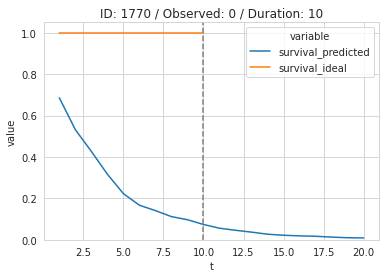

In [13]:
observed = 0

random_id = 1770 ## data_test.loc[data_test.observed==observed, id_col].sample().squeeze()
surv_id_df = surv_df.loc[surv_df[id_col].to_numpy()==random_id, ['t', 'survival']].copy()
surv_id_df = surv_id_df.rename(columns={'survival': 'survival_predicted'})

duration = data_test[data_test[id_col].to_numpy()==random_id].duration.squeeze()
observed = data_test[data_test[id_col].to_numpy()==random_id].observed.squeeze()

surv_id_df['survival_ideal'] = duration * [1] + (len(surv_id_df)-duration) * [np.NaN]
surv_id_df = surv_id_df.melt(id_vars='t').copy()


sns.lineplot(data=surv_id_df, 
             x='t', 
             y='value',
            hue='variable')
plt.title(f'ID: {random_id} / '
          f'Observed: {observed} / '
          f'Duration: {duration}')
plt.axvline(duration, c='grey', linestyle='--')
plt.ylim(0,1.05);

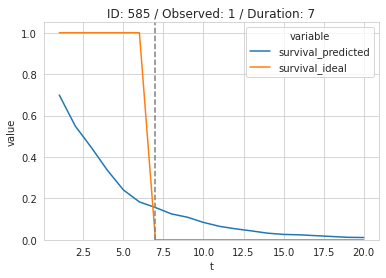

In [14]:
observed = 1

random_id = 585 ## data_test.loc[data_test.observed==observed, id_col].sample().squeeze() ## 948
surv_id_df = surv_df.loc[surv_df[id_col].to_numpy()==random_id, ['t', 'survival']].copy()
surv_id_df = surv_id_df.rename(columns={'survival': 'survival_predicted'})

duration = data_test[data_test[id_col].to_numpy()==random_id].duration.squeeze()
observed = data_test[data_test[id_col].to_numpy()==random_id].observed.squeeze()

surv_id_df['survival_ideal'] = (duration-1) * [1] + (len(surv_id_df)-duration+1) * [0]
surv_id_df = surv_id_df.melt(id_vars='t').copy()


sns.lineplot(data=surv_id_df, 
             x='t', 
             y='value',
            hue='variable')
plt.title(f'ID: {random_id} / '
          f'Observed: {observed} / '
          f'Duration: {duration}')
plt.axvline(duration, c='grey', linestyle='--')
plt.ylim(0,1.05);

## Single ID

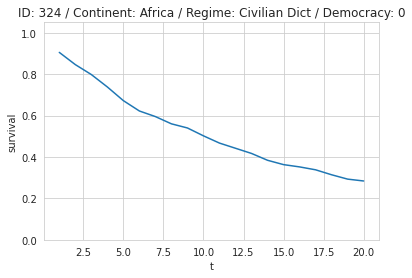

In [15]:
random_id = surv_df[id_col].sample().squeeze()
surv_id_df = surv_df[surv_df[id_col].to_numpy()==random_id].copy()

sns.lineplot(data=surv_id_df, 
             x='t', 
             y='survival')
plt.title(f'ID: {random_id} / '
          f'Continent: {surv_id_df.un_continent_name.iloc[0]} / '
          f'Regime: {surv_id_df.regime.iloc[0]} / '
          f'Democracy: {surv_id_df.democracy.iloc[0]}')
plt.ylim(0,1.05);

## Overall Average

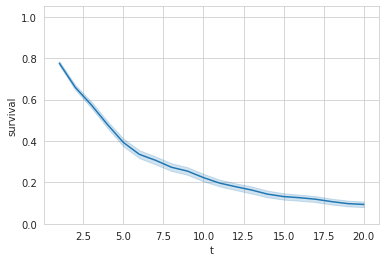

In [16]:
sns.lineplot(data=surv_df, # Faster, no CI: data=surv_df.groupby(['t']).agg({'survival': 'mean'}).reset_index(), 
             x='t', 
             y='survival')
plt.ylim(0,1.05);

## Democracy

,democracy,survival
0,0,0.45
1,1,0.18


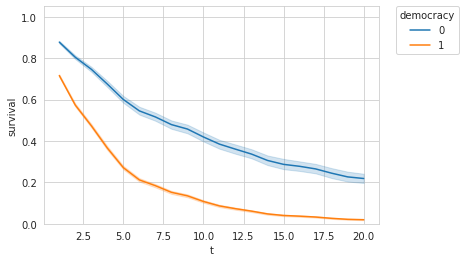

In [17]:
by_col = 'democracy'

display(surv_df.groupby([by_col], as_index=False).agg({'survival': 'mean'}).round(2).sort_values('survival', ascending=False))

sns.lineplot(data=surv_df, # data=surv_df.groupby(['t', by_col]).agg({'survival': 'mean'}).reset_index(),
             x='t', 
             y='survival', 
             hue=by_col)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=by_col)
plt.ylim(0,1.05);

## Continent

,un_continent_name,survival
0,Africa,0.43
2,Asia,0.32
1,Americas,0.25
4,Oceania,0.23
3,Europe,0.19


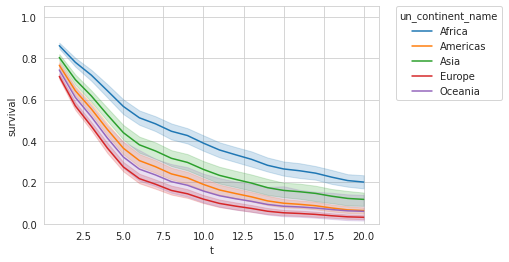

In [18]:
by_col = 'un_continent_name'

display(surv_df.groupby([by_col], as_index=False).agg({'survival': 'mean'}).round(2).sort_values('survival', ascending=False))

sns.lineplot(data=surv_df, # data=surv_df.groupby(['t', by_col]).agg({'survival': 'mean'}).reset_index(),
             x='t', 
             y='survival', 
             hue=by_col)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=by_col)
plt.ylim(0,1.05);

## Regime

,regime,survival
3,Monarchy,0.82
0,Civilian Dict,0.46
1,Military Dict,0.39
4,Parliamentary Dem,0.20
5,Presidential Dem,0.17
2,Mixed Dem,0.14


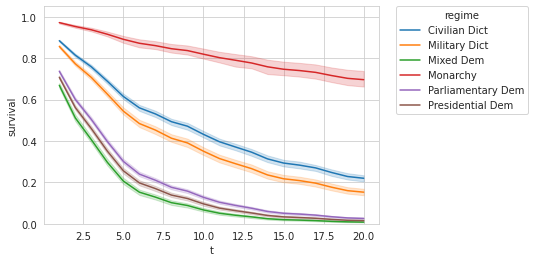

In [19]:
by_col = 'regime'

display(surv_df.groupby([by_col], as_index=False).agg({'survival': 'mean'}).round(2).sort_values('survival', ascending=False))

sns.lineplot(data=surv_df, # data=surv_df.groupby(['t', by_col]).agg({'survival': 'mean'}).reset_index(),
             x='t', 
             y='survival', 
             hue=by_col)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=by_col)
plt.ylim(0,1.05);

# Metrics

In [20]:
surv_avg = y_pred_surv.iloc[:prediction_horizon].mean(axis=0).mean()
eval_obj = EvalSurv(y_pred_surv, np.array(test.duration.to_numpy()), np.array(test.observed.to_numpy()), censor_surv='km')

ctd = eval_obj.concordance_td('antolini')

t_eval_grid = np.array(range(1, prediction_horizon+1))
brier_mean = np.mean(eval_obj.brier_score(t_eval_grid)[:prediction_horizon])
brier_1 = eval_obj.brier_score(t_eval_grid).iloc[5]
brier_2 = eval_obj.brier_score(t_eval_grid).iloc[10]
brier_3 = eval_obj.brier_score(t_eval_grid).iloc[15]

cols=['Surv_Avg', 'CTD', 'Brier_Mean', 'Brier_5', 'Brier_10', 'Brier_15']
eval_df = pd.DataFrame([(surv_avg, ctd, brier_mean, brier_1, brier_2, brier_3)], columns=cols)

eval_df.round(3)

,Surv_Avg,CTD,Brier_Mean,Brier_5,Brier_10,Brier_15
0,0.282,0.594,0.132,0.18,0.092,0.078


# Understand Brier Score

## Mean

In [21]:
brier_t = eval_obj.brier_score(t_eval_grid)[:prediction_horizon]

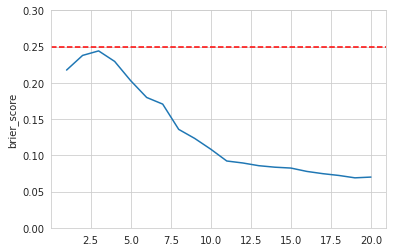

In [22]:
sns.lineplot(data=brier_t)
plt.axhline(0.25, c='r', linestyle='--')
plt.ylim(0, 0.3);

## Single Observation

Only working for single observation if event was observed

In [23]:
ids_observed = data_test.loc[data_test.observed==1, id_col].squeeze().to_list()
data_test = data_test.reset_index(drop=True)

In [24]:
id_obs = ids_observed[0]
brier_means = []

for id_obs in ids_observed:
    idx_obs = data_test[data_test[id_col]==id_obs].index.values[0]
    eval_obj = EvalSurv(pd.DataFrame(y_pred_surv[idx_obs]), 
                        np.array([test.iloc[idx_obs].duration]), 
                        np.array([test.iloc[idx_obs].observed]), 
                        censor_surv='km')
    brier_t = eval_obj.brier_score(t_eval_grid)[:prediction_horizon]
    brier_mean = np.mean(brier_t)
    brier_means.append([id_obs, brier_mean, brier_t])
    
brier_df = pd.DataFrame(brier_means, columns=[id_col[0], 'brier_mean', 'brier_t']).sort_values('brier_mean').round(3)
brier_df.sample(5)

,r,brier_mean,brier_t
261,141,0.186,1 0.012769 2 0.032761 3 0.583696 4...
7,532,0.033,1 0.135424 2 0.287296 3 0.126736 4...
124,1773,0.143,1 0.010816 2 0.028224 3 0.047961 4...
199,599,0.057,1 0.053361 2 0.126025 3 0.306916 4...
102,1230,0.038,1 0.092416 2 0.207025 3 0.195364 4...


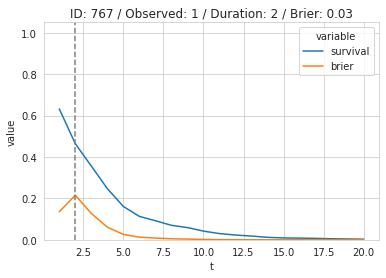

In [25]:
random_id = 767 ## data_test.loc[data_test.observed==observed, id_col].sample().squeeze()
brier_score = brier_df.loc[brier_df[id_col[0]]==random_id, "brier_mean"].squeeze()
brier_t = brier_df.loc[brier_df[id_col[0]]==random_id, "brier_t"].squeeze()

surv_id_df = surv_df[surv_df[id_col].to_numpy()==random_id].copy()
surv_id_df['brier'] = brier_t.values
surv_melt = surv_id_df.melt(id_vars='t', value_vars=['survival', 'brier'])

duration = data_test[data_test[id_col].to_numpy()==random_id].duration.squeeze()

sns.lineplot(data=surv_melt, 
             x='t', 
             y='value',
             hue='variable')

plt.title(f'ID: {random_id} / '
          f'Observed: {observed} / '
          f'Duration: {duration} / '
          f'Brier: {brier_score}')

plt.axvline(duration, c='grey', linestyle='--')
# plt.axhline(0.25, c='orange', linestyle='--')
plt.ylim(0,1.05);

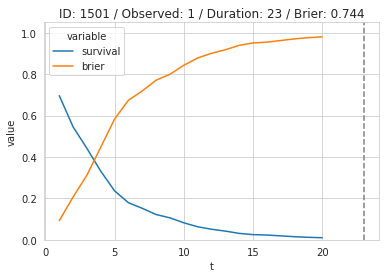

In [26]:
random_id = 1501 ## data_test.loc[data_test.observed==observed, id_col].sample().squeeze()
brier_score = brier_df.loc[brier_df[id_col[0]]==random_id, "brier_mean"].squeeze()
brier_t = brier_df.loc[brier_df[id_col[0]]==random_id, "brier_t"].squeeze()

surv_id_df = surv_df[surv_df[id_col].to_numpy()==random_id].copy()
surv_id_df['brier'] = brier_t.values
surv_melt = surv_id_df.melt(id_vars='t', value_vars=['survival', 'brier'])

duration = data_test[data_test[id_col].to_numpy()==random_id].duration.squeeze()

sns.lineplot(data=surv_melt, 
             x='t', 
             y='value',
             hue='variable')

plt.title(f'ID: {random_id} / '
          f'Observed: {observed} / '
          f'Duration: {duration} / '
          f'Brier: {brier_score}')

plt.axvline(duration, c='grey', linestyle='--')
# plt.axhline(0.25, c='orange', linestyle='--')
plt.ylim(0,1.05);

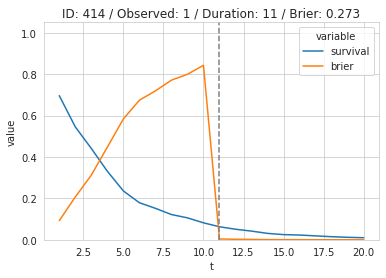

In [27]:
random_id = data_test.loc[(data_test.observed==observed) & (data_test.duration>10), id_col].sample().squeeze()
brier_score = brier_df.loc[brier_df[id_col[0]]==random_id, "brier_mean"].squeeze()
brier_t = brier_df.loc[brier_df[id_col[0]]==random_id, "brier_t"].squeeze()

surv_id_df = surv_df[surv_df[id_col].to_numpy()==random_id].copy()
surv_id_df['brier'] = brier_t.values
surv_melt = surv_id_df.melt(id_vars='t', value_vars=['survival', 'brier'])

duration = data_test[data_test[id_col].to_numpy()==random_id].duration.squeeze()

sns.lineplot(data=surv_melt, 
             x='t', 
             y='value',
             hue='variable')

plt.title(f'ID: {random_id} / '
          f'Observed: {observed} / '
          f'Duration: {duration} / '
          f'Brier: {brier_score}')

plt.axvline(duration, c='grey', linestyle='--')
# plt.axhline(0.25, c='orange', linestyle='--')
plt.ylim(0,1.05);

# Survival Distribution @ t

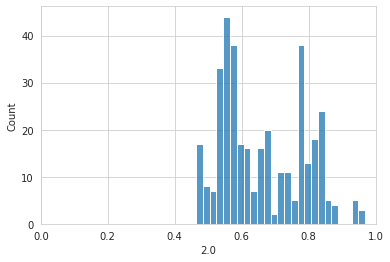

In [28]:
t=1
sns.histplot(y_pred_surv.iloc[t], bins=25)
plt.xlim(0, 1);

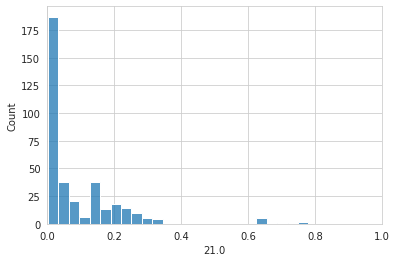

In [29]:
t=prediction_horizon
sns.histplot(y_pred_surv.iloc[t], bins=25)
plt.xlim(0, 1);

# Dynamic AUC

In [30]:
hazards = cph.predict_partial_hazard(test)

In [31]:
train[event_col] = train[event_col].astype('bool')
test[event_col] = test[event_col].astype('bool')

In [32]:
auc = cumulative_dynamic_auc(train[[event_col, duration_col]].to_records(index=False), 
                       test[[event_col, duration_col]].to_records(index=False), 
                       hazards, 
                       t_eval_grid)

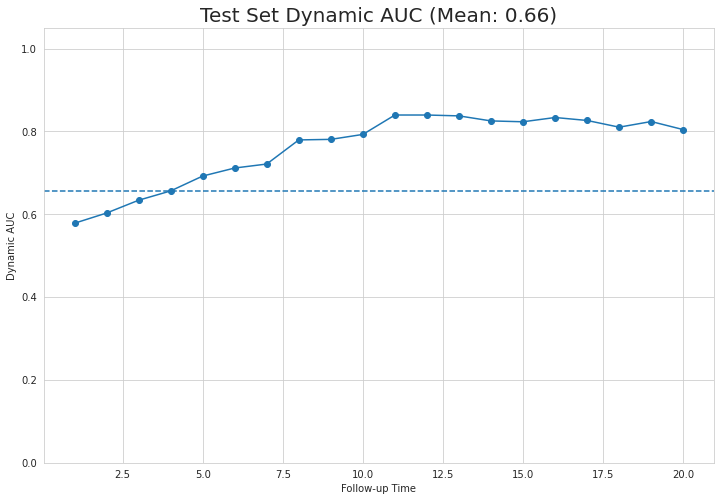

In [33]:
plt.figure(figsize = (12,8))
plt.plot(t_eval_grid, auc[0], marker = 'o')
plt.axhline(auc[1], linestyle = '--')
plt.title(f'Test Set Dynamic AUC (Mean: {auc[1].round(2)})', fontsize = 20)
plt.xlabel('Follow-up Time')
plt.ylabel('Dynamic AUC')
plt.ylim(0,1.05);